In [27]:
import numpy as np
import pandas as pd
import k2
import torch
import pickle
import sys
from math import floor
import struct
import time
import sentencepiece as spm
import jiwer as jw
import difflib as dl
import nltk
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
#nltk.download('punkt')

Importing the FSA binary file. I have to augment the recursion limit so the kernel doesn't crash.

In [28]:
sys.setrecursionlimit(10000)

with open("../data/lattice_cpu4.pt", 'rb') as file:
    fsa = k2.Fsa.from_dict(torch.load(file, map_location=torch.device('cpu')))

with open("../data/lattice_new.ref", 'rb') as file:
    ref = pickle.load(file)


#print(fsa.shape)
#print(ref[0][0])
    

In [29]:
bpe_model = spm.SentencePieceProcessor()

bpe_model.load("../data/bpe_500/bpe.model")


True

int32_to_float converts a number encoded as a signed 32bits integer to a float.

In [30]:
def int32_to_float(number):
    if(np.issubdtype(type(number), np.integer)):
        return struct.unpack('f', struct.pack('i', number))[0]
    else:
        return number

In [31]:
def compute_backward(fsa, index):
    tensor = torch.tensor([index], dtype=torch.int32)
    fsa_index = k2.index_fsa(fsa, tensor)
    back_scores = fsa_index._get_backward_scores(True,True)
    return back_scores.numpy()

In [32]:
def successors(fsa_list, cur_node, backward, factor):
    successors = []
    scores_LLM = []
    for node in fsa_list:
        if(node[0] == cur_node[1]):
            new_list = cur_node[2].copy()
            new_list.append(node[2])
            score = int32_to_float(cur_node[3]) + int32_to_float(node[3]) + backward[node[1]]
            #score_LLM  = rescore_LLM_2(new_list, score, .1)
            #successors.append([cur_node[0], node[1], new_list, score_LLM])
            #scores_LLM.append(score_LLM)
            successors.append([cur_node[0], node[1], new_list, score])
        else:
            continue
    return successors, scores_LLM

insertion_sort sorts any list of nodes.

In [33]:
def insertion_sort(fsa_list):
    for i in range(1, len(fsa_list)):
        key = fsa_list[i]
        j = i - 1
        while j >= 0 and key[3] > fsa_list[j][3]:
            fsa_list[j + 1] = fsa_list[j]
            j -= 1
        fsa_list[j + 1] = key
    return fsa_list

Implementing the rescoring LLM function

In [34]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`


In [35]:
def rescore_LLM(hyps):
    n_best_list = []
    for hyp in hyps:
        sentence_tokens = hyp[2]
        scores = hyp[-1]
        ours = copy(decode(sentence_tokens))
        sentence = bpe_model.decode(ours)
        n_best_list.append({"node": hyp, "sentence": sentence, "score": scores})
    rescored_list = []
    for hypothesis in n_best_list:
        text = hypothesis["sentence"]
        input_ids = tokenizer.encode(text, return_tensors="pt")
        with torch.no_grad():
            outputs = model(input_ids)
        log_probabilities = outputs.logits[:, -1, :]
        # Assuming you are using log probabilities, you can transform it into probabilities if needed.
        new_score = hypothesis["score"] + log_probabilities[0, -1].item()
        rescored_list.append([hypothesis["node"][0], hypothesis["node"][1], hypothesis["node"][2], new_score])
    return rescored_list

Rescores individual hypotheses

In [36]:
def rescore_LLM_2(hyp, score, coeff):
    ours = copy(decode(sentence_tokens))
    sentence = bpe_model.decode(ours)
    rescored_list = []
    input_ids = tokenizer.encode(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = model(input_ids)
    log_probabilities = outputs.logits[:, -1, :]
    # Assuming you are using log probabilities, you can transform it into probabilities if needed.
    new_score = score + log_probabilities[0, -1].item()*coeff

    t = time.time() - start
    return new_score

First implementation of the stack decoder, without any pruning.

In [37]:
def stack_decoder(fsa):

    fsa = k2.to_tensor(fsa[7]).numpy() # convert fsa to numpy array
    
    open =[]
    closed = []

    start = fsa[0][0]
    end = fsa[-1][1]

    i = 0
    while(fsa[i][0] == start): # find all arcs that start at the start state
        open.append([fsa[i][0], fsa[i][1], [fsa[i][2]], fsa[i][3]])
        i += 1
    
    i = 0
    while(len(open) > 0):
        for cur_node in open:
            if(cur_node[2] == -1):
                return closed
            suc_nodes = successors(fsa, cur_node)
            open.remove(cur_node)
            closed.append(cur_node)
            open.extend(suc_nodes)
            insertion_sort(closed)
            """if(i // 20 == 0):
                del_index = -len(closed)%10
                del closed[del_index:]"""
            i+=1
    
    return closed

Second implementation of a stack decoder, using prunning in list of nodes to explore (open). Thus, we only explore the most promising path. Not taking the forward/backward functions into account yet.

In [38]:
def stack_decoder_partial(fsa, num, factor, threshold):

    backward = compute_backward(fsa, num)

    fsa = k2.to_tensor(fsa[num]).numpy() # convert fsa to numpy array
    open =[]
    closed = []


    start = fsa[0][0]
    end = fsa[-1][1]

    i = 0
    while(fsa[i][0] == start): # find all arcs that start at the start state
        open.append([fsa[i][0], fsa[i][1], [fsa[i][2]], fsa[i][3] + backward[fsa[i][1]]])
        i+=1
    
    i=0
    while(len(open) > 0):
        for cur_node in open:
            if(cur_node[2] == -1):
                return closed
            suc_nodes = successors(fsa, cur_node, backward, factor)[0]
            open.remove(cur_node)
            closed.append(cur_node)
            open.extend(suc_nodes)
            insertion_sort(open)
            if(len(open) > 10):
                del_index = floor(len(open) * threshold)
                del open[-del_index:]
        i+=1

    rescored = rescore_LLM(closed[-5:])
    closed = insertion_sort(rescored)
    return closed

Associates tokens to their related string and outpus the final sentence.

In [39]:
def decode(sentence_tokens):
    tokens = []

    for i in sentence_tokens:
        if i == -1:
            break
        elif i == 0:
            continue
        tokens.append(i)
    

    return tokens

In [40]:
def word_error_rate(ref, hyp):
    return jw.wer(ref, hyp)

I obtained a really strange error: decode doesn't work with output token sequence defined by a function but does with the same output function defined as-is. I have to convert the list elements to strings and then back to ints.

In [41]:
def copy(list):
    list_str= []
    list_out= []

    for i in list: #Converts to string
        var = str(i)
        list_str.append(var)

    for i in list_str: #Converts back to ints
        var = int(i)
        list_out.append(var)
    return(list_out)

TESTING


-27.509386018011604
--- 1.6017451286315918 seconds ---


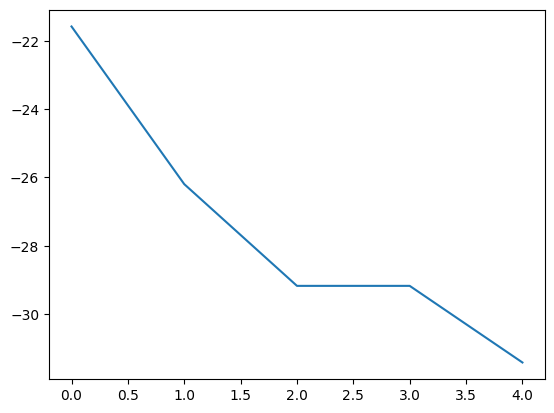

In [42]:
start_time = time.time()

decoded_partial = stack_decoder_partial(fsa, 20, 1, .99)

sentence_tokens = decoded_partial[-1][2]

scores = []

for i in decoded_partial:
    scores.append(i[3])

plt.plot(scores)
print(np.mean(scores))


print("--- %s seconds ---" % (time.time() - start_time))

In [43]:
start_time = time.time()

one_best = k2.one_best_decoding(fsa)
one_best_tensor = k2.to_tensor(one_best[20]).numpy()
st_one_best = []
for i in one_best_tensor:
    st_one_best.append(i[2])

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.8492579460144043 seconds ---


In [44]:
ours = copy(decode(sentence_tokens))

k2_decode = copy(decode(st_one_best))


In [45]:
start = time.time()
ours_decoded = bpe_model.decode(ours)

k2_decoded = bpe_model.decode(k2_decode)
ref_decoded = ref[10]
print("Time for ours: ", time.time() - start)

print("Ours is : ", ours_decoded)
print("k2 is : ", k2_decoded)
print("Ground Truth is : ", ref_decoded)

Time for ours:  0.0010089874267578125
Ours is :  THE DEAD MUST BE OBEYED TO BE BURIED IN THE VAULT UNDER THE ALTAR OF THE CHAPEL NOT TO GO TO PROFAIN EARTH TO REMAIN THERE IN DEATH WHERE SHE PRARAYED WHILE LIVING SUCH WAS THE LAST WISH OF MOTHER CRUCIFICXIONION
k2 is :  THE DEAD MUST BE OBEYED TO BE BURIED IN THE VAULT UNDER THE ALTAR OF THE CHAPEL NOT TO GO TO PROFAIN EARTH TO REMAIN THERE IN DEATH WHERE SHE PRARAYED WHILE LIVING SUCH WAS THE LAST WISH OF MOTHER CRUCIFICION
Ground Truth is :  YET IT WAS NO ILLUSION THAT DECEIVED HIM


In [46]:
def wer(r, h):

    r = nltk.word_tokenize(r)
    h = nltk.word_tokenize(h)

    """
    This function returns the word error rate (WER) given two lists of strings:
    r (reference) and h (hypothesis).
    """
    # Create a dictionary of words and their counts in the reference text
    ref_dict = {}
    for word in r:
        if word not in ref_dict:
            ref_dict[word] = 1
        else:
            ref_dict[word] += 1

    # Create a dictionary of words and their counts in the hypothesis text
    hyp_dict = {}
    for word in h:
        if word not in hyp_dict:
            hyp_dict[word] = 1
        else:
            hyp_dict[word] += 1

    # Calculate the number of substitutions, deletions, and insertions
    substitutions = 0
    deletions = 0
    insertions = 0
    for word in ref_dict.keys():
        if word not in hyp_dict:
            deletions += ref_dict[word]
        elif hyp_dict[word] < ref_dict[word]:
            substitutions += hyp_dict[word]
            deletions += ref_dict[word] - hyp_dict[word]
        elif hyp_dict[word] > ref_dict[word]:
            substitutions += ref_dict[word]
            insertions += hyp_dict[word] - ref_dict[word]
        else:
            substitutions += ref_dict[word]

    # Calculate the WER
    wer = (substitutions + deletions + insertions)

    return wer, substitutions, deletions, insertions

# Example usage



In [47]:
wer_score = wer(ours_decoded, ref_decoded)
wer_k2_score = wer(k2_decoded, ref_decoded)

Our algorithm's performances on test lattice

In [48]:
subs = []
dels = []
ins = []
avg_time = []

sub_plot = []
del_plot = []
ins_plot = []
time_plot = []



for i in range(30):
    start_time = time.time()
    decoded_partial = stack_decoder_partial(fsa, i, 1, .99)
    sentence_tokens = decoded_partial[-1][2]
    ours = copy(decode(sentence_tokens))
    ours_decoded = bpe_model.decode(ours)

    #print("Our decoded: ", ours_decoded, "Ref: ", ref[i])
    wer_score = wer(ours_decoded, ref[i])
    subs.append(wer_score[1])
    dels.append(wer_score[2])
    ins.append(wer_score[3])
    avg_time.append(time.time() - start_time)
    
print("Average time: ", np.mean(avg_time))
time_plot.append(np.mean(avg_time))
print("Substitutions: ", np.mean(subs))
sub_plot.append(np.mean(subs)/30)
print("Deletions: ", np.mean(dels))
del_plot.append(np.mean(dels)/30)
print("Insertions: ", np.mean(ins))
ins_plot.append(np.mean(ins)/30)
print("WER :", np.mean(subs)/30 + np.mean(dels)/30 + np.mean(ins)/30, '/n')



KeyboardInterrupt: 

Taking a look at the 5-best list of hypothesis

In [49]:
print("ref: ", ref[0])

for i in range(1,6):
    decoded_partial = stack_decoder_partial(fsa, 0, 1, .5)
    sentence_tokens = decoded_partial[-i][2]
    ours = copy(decode(sentence_tokens))
    ours_decoded = bpe_model.decode(ours)
    print("hyp", i, ": ", ours_decoded)
    #print("Our decoded: ", ours_decoded, "Ref: ", ref[i])
    wer_score = wer(ours_decoded, ref[i])
    subs.append(wer_score[1])
    dels.append(wer_score[2])
    ins.append(wer_score[3])
    avg_time.append(time.time() - start_time)

ref:  THEN I TOOK UP A GREAT STONE FROM AMONG THE TREES AND COMING UP TO HIM SMOTE HIM THEREWITH ON THE HEAD WITH ALL MY MIGHT AND CRUSHED IN HIS SKULL AS HE LAY DEAD DRUNK
hyp 1 :  THEN I TOOK UP A GREAT STONE FROM AMONG THE TREES AND COMING UP TO HIM SMTEE HIM THERE WITHTH ON THE HEAD WITH ALL MY MIGHT AND CRUSHEDED IN HIS SCHULL AS HE LIE DEAD DRUN
hyp 2 :  THEN I TOOK UP A GREAT STONE FROM AMONG THE TREES AND COMING UP TO HIM SMTEE HIM THERE WITHTH ON THE HEAD WITH ALL MY MIGHT AND CRUSHEDED IN HIS SCHULL AS HE LIE DEAD DRUN
hyp 3 :  THEN I TOOK UP A GREAT STONE FROM AMONG THE TREES AND COMING UP TO HIM SMTEE HIM THERE WITHTH ON THE HEAD WITH ALL MY MIGHT AND CRUSHEDED IN HIS SCHULL AS HE LIE DEAD DRUNK
hyp 4 :  THEN I TOOK UP A GREAT STONE FROM AMONG THE TREES AND COMING UP TO HIM SMTEE HIM THERE WITHTH ON THE HEAD WITH ALL MY MIGHT AND CRUSHEDED IN HIS SCHULL AS HE LIE DEAD DRUNK
hyp 5 :  THEN I TOOK UP A GREAT STONE FROM AMONG THE TREES AND COMING UP TO HIM SMTEE HIM THERE WITHT

ValueError: x and y must have same first dimension, but have shapes (6,) and (0,)

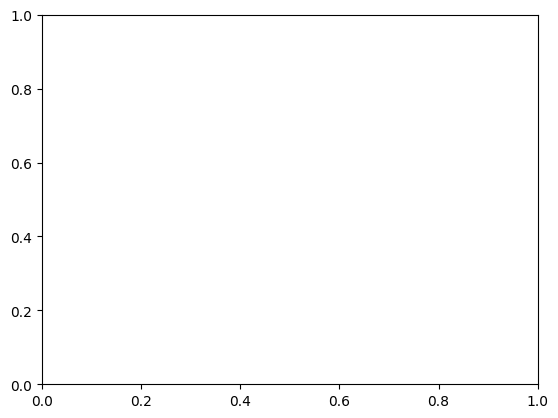

In [50]:
plt.plot([1,10,100,1000,10000,100000], time_plot, label="Time")
plt.plot([1,10,100,1000,10000,100000], sub_plot, label="Substitutions")
plt.plot([1,10,100,1000,10000,100000], del_plot, label="Deletions")
plt.plot([1,10,100,1000,10000,100000], ins_plot, label="Insertions")
plt.legend()

k2 performances

In [51]:
subs = []
dels = []
ins = []
avg_time = []

for i in range(30):
    start = time.time()
    one_best = k2.one_best_decoding(fsa)
    one_best_tensor = k2.to_tensor(one_best[i]).numpy()
    st_one_best = []
    for j in one_best_tensor:
        st_one_best.append(j[2])
    k2_decode = copy(decode(st_one_best))
    k2_decoded = bpe_model.decode(k2_decode)
    wer_score = wer(k2_decoded, ref[i])
    subs.append(wer_score[1])
    dels.append(wer_score[2])
    ins.append(wer_score[3])
    avg_time.append(time.time() - start)

print("Average time: ", np.mean(avg_time))
time_plot.append(np.mean(avg_time))
print("Substitutions: ", np.mean(subs))
sub_plot.append(np.mean(subs))
print("Deletions: ", np.mean(dels))
del_plot.append(np.mean(dels))
print("Insertions: ", np.mean(ins))
ins_plot.append(np.mean(ins))
print("WER: ", np.mean(subs)/30 + np.mean(dels)/30 + np.mean(ins)/30, '/n')


Average time:  0.05135098298390706
Substitutions:  17.833333333333332
Deletions:  5.333333333333333
Insertions:  0.4
WER:  0.7855555555555555 /n


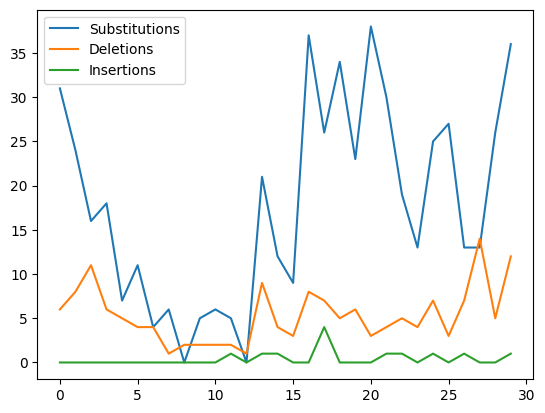

In [52]:
plt.plot(subs, label="Substitutions")
plt.plot(dels, label="Deletions")
plt.plot(ins, label="Insertions")
plt.legend()

Implementation of backward scores

We can implement it in 2 ways: 
*By converting a single Fsa to an FsaVec and computing the backward scores on it
*By computing the whole backward scores and reading 


In [53]:
"""back_scores = fsa._get_backward_scores(True,True)
fsa_tensor = k2.to_tensor(fsa).numpy()
print(back_scores.shape)
print(back_scores[-10:])
print(back_scores[468:478])
"""

'back_scores = fsa._get_backward_scores(True,True)\nfsa_tensor = k2.to_tensor(fsa).numpy()\nprint(back_scores.shape)\nprint(back_scores[-10:])\nprint(back_scores[468:478])\n'

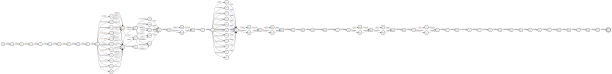

In [54]:
k2.to_dot(fsa[10])

Comparison on the different exits


In [55]:
import ast

def extract_reference(line):
    start_index = line.index('ref=') + 4  # The "+4" is to skip 'ref='
    list_string = line[start_index:]
    ref_list = ast.literal_eval(list_string)
    sentence = ' '.join(word for word in ref_list)
    return sentence

def create_refs(file):
    ref_list = []
    for line in file:
        if 'ref=' in line:
            ref_list.append(extract_reference(line))
    return ref_list



Exit 0

In [56]:
"""with open("../data/lattice-ctc-avg/clean/0/lattice.ctc/lattice.ctc", 'rb') as file:
    fsa_0 = k2.Fsa.from_dict(torch.load(file, map_location=torch.device('cpu')))

with open("G:/TSP/Internship/FBK/data/lattice-ctc-avg/clean/1/recogs-test-clean-no_rescore.txt", 'r') as file:
    ref_0 = file.readlines()
    ref_0 = [line.strip() for line in ref_0]

ref_0_text = create_refs(ref_0)

with open("../data/lattice-ctc-avg/clean/0/lattice.ctc/ref_0.pt", 'wb') as file:
    pickle.dump(ref_0_text, file)"""

'with open("../data/lattice-ctc-avg/clean/0/lattice.ctc/lattice.ctc", \'rb\') as file:\n    fsa_0 = k2.Fsa.from_dict(torch.load(file, map_location=torch.device(\'cpu\')))\n\nwith open("G:/TSP/Internship/FBK/data/lattice-ctc-avg/clean/1/recogs-test-clean-no_rescore.txt", \'r\') as file:\n    ref_0 = file.readlines()\n    ref_0 = [line.strip() for line in ref_0]\n\nref_0_text = create_refs(ref_0)\n\nwith open("../data/lattice-ctc-avg/clean/0/lattice.ctc/ref_0.pt", \'wb\') as file:\n    pickle.dump(ref_0_text, file)'

Exit 1

In [57]:
"""with open("../data/lattice-ctc-avg/clean/1/lattice.ctc/lattice.ctc", 'rb') as file:
    fsa_1 = k2.Fsa.from_dict(torch.load(file, map_location=torch.device('cpu')))

with open("G:/TSP/Internship/FBK/data/lattice-ctc-avg/clean/0/recogs-test-clean-no_rescore.txt", 'r') as file:
    ref_1 = file.readlines()
    ref_1 = [line.strip() for line in ref_1]

ref_1_text = create_refs(ref_1)

#with open("../data/lattice-ctc-avg/clean/1/lattice.ctc/ref_1.pt", "wb") as fp:   #Pickling
#    pickle.dump(ref_1_text, fp)"""

'with open("../data/lattice-ctc-avg/clean/1/lattice.ctc/lattice.ctc", \'rb\') as file:\n    fsa_1 = k2.Fsa.from_dict(torch.load(file, map_location=torch.device(\'cpu\')))\n\nwith open("G:/TSP/Internship/FBK/data/lattice-ctc-avg/clean/0/recogs-test-clean-no_rescore.txt", \'r\') as file:\n    ref_1 = file.readlines()\n    ref_1 = [line.strip() for line in ref_1]\n\nref_1_text = create_refs(ref_1)\n\n#with open("../data/lattice-ctc-avg/clean/1/lattice.ctc/ref_1.pt", "wb") as fp:   #Pickling\n#    pickle.dump(ref_1_text, fp)'

Exit 2

In [58]:
"""with open("../data/lattice-ctc-avg/clean/2/lattice.ctc/lattice.ctc", 'rb') as file:
    fsa_2 = k2.Fsa.from_dict(torch.load(file, map_location=torch.device('cpu')))

with open("G:/TSP/Internship/FBK/data/lattice-ctc-avg/clean/2/recogs-test-clean-no_rescore.txt", 'r') as file:
    ref_2 = file.readlines()
    ref_2 = [line.strip() for line in ref_2]

ref_2_text = create_refs(ref_2)

#with open("../data/lattice-ctc-avg/clean/2/lattice.ctc/ref_2.pt", 'wb') as file:
#    pickle.dump(ref_2_text, file)"""

'with open("../data/lattice-ctc-avg/clean/2/lattice.ctc/lattice.ctc", \'rb\') as file:\n    fsa_2 = k2.Fsa.from_dict(torch.load(file, map_location=torch.device(\'cpu\')))\n\nwith open("G:/TSP/Internship/FBK/data/lattice-ctc-avg/clean/2/recogs-test-clean-no_rescore.txt", \'r\') as file:\n    ref_2 = file.readlines()\n    ref_2 = [line.strip() for line in ref_2]\n\nref_2_text = create_refs(ref_2)\n\n#with open("../data/lattice-ctc-avg/clean/2/lattice.ctc/ref_2.pt", \'wb\') as file:\n#    pickle.dump(ref_2_text, file)'

Exit 3

In [59]:
"""with open("../data/lattice-ctc-avg/clean/3/lattice.ctc/lattice.ctc", 'rb') as file:
    fsa_3 = k2.Fsa.from_dict(torch.load(file, map_location=torch.device('cpu')))

with open("G:/TSP/Internship/FBK/data/lattice-ctc-avg/clean/3/recogs-test-clean-no_rescore.txt", 'r') as file:
    ref_3 = file.readlines()
    ref_3 = [line.strip() for line in ref_3]

ref_3_text = create_refs(ref_3)

#with open("../data/lattice-ctc-avg/clean/3/lattice.ctc/ref_3.pt", 'wb') as file:
#    pickle.dump(ref_3_text, file)"""

'with open("../data/lattice-ctc-avg/clean/3/lattice.ctc/lattice.ctc", \'rb\') as file:\n    fsa_3 = k2.Fsa.from_dict(torch.load(file, map_location=torch.device(\'cpu\')))\n\nwith open("G:/TSP/Internship/FBK/data/lattice-ctc-avg/clean/3/recogs-test-clean-no_rescore.txt", \'r\') as file:\n    ref_3 = file.readlines()\n    ref_3 = [line.strip() for line in ref_3]\n\nref_3_text = create_refs(ref_3)\n\n#with open("../data/lattice-ctc-avg/clean/3/lattice.ctc/ref_3.pt", \'wb\') as file:\n#    pickle.dump(ref_3_text, file)'

Exit 4


In [60]:
"""with open("../data/lattice-ctc-avg/clean/4/lattice.ctc/lattice.ctc", 'rb') as file:
    fsa_4 = k2.Fsa.from_dict(torch.load(file, map_location=torch.device('cpu')))

with open("G:/TSP/Internship/FBK/data/lattice-ctc-avg/clean/4/recogs-test-clean-no_rescore.txt", 'r') as file:
    ref_4 = file.readlines()
    ref_4 = [line.strip() for line in ref_4]

ref_4_text = create_refs(ref_4)

#with open("../data/lattice-ctc-avg/clean/4/lattice.ctc/ref_4.pt", 'wb') as file:
#    pickle.dump(ref_4_text, file)"""

'with open("../data/lattice-ctc-avg/clean/4/lattice.ctc/lattice.ctc", \'rb\') as file:\n    fsa_4 = k2.Fsa.from_dict(torch.load(file, map_location=torch.device(\'cpu\')))\n\nwith open("G:/TSP/Internship/FBK/data/lattice-ctc-avg/clean/4/recogs-test-clean-no_rescore.txt", \'r\') as file:\n    ref_4 = file.readlines()\n    ref_4 = [line.strip() for line in ref_4]\n\nref_4_text = create_refs(ref_4)\n\n#with open("../data/lattice-ctc-avg/clean/4/lattice.ctc/ref_4.pt", \'wb\') as file:\n#    pickle.dump(ref_4_text, file)'

Exit 5



In [61]:
"""with open("../data/lattice-ctc-avg/clean/5/lattice.ctc/lattice.ctc", 'rb') as file:
    fsa_5 = k2.Fsa.from_dict(torch.load(file, map_location=torch.device('cpu')))

with open("G:/TSP/Internship/FBK/data/lattice-ctc-avg/clean/5/recogs-test-clean-no_rescore.txt", 'r') as file:
    ref_5 = file.readlines()
    ref_5 = [line.strip() for line in ref_5]

ref_5_text = create_refs(ref_5)

with open("../data/lattice-ctc-avg/clean/5/lattice.ctc/ref_5.pt", 'wb') as file:
    pickle.dump(ref_5_text, file)"""

'with open("../data/lattice-ctc-avg/clean/5/lattice.ctc/lattice.ctc", \'rb\') as file:\n    fsa_5 = k2.Fsa.from_dict(torch.load(file, map_location=torch.device(\'cpu\')))\n\nwith open("G:/TSP/Internship/FBK/data/lattice-ctc-avg/clean/5/recogs-test-clean-no_rescore.txt", \'r\') as file:\n    ref_5 = file.readlines()\n    ref_5 = [line.strip() for line in ref_5]\n\nref_5_text = create_refs(ref_5)\n\nwith open("../data/lattice-ctc-avg/clean/5/lattice.ctc/ref_5.pt", \'wb\') as file:\n    pickle.dump(ref_5_text, file)'

In [62]:
with open("../data/lattice-ctc-avg/clean/0/lattice.ctc/lattice.ctc", 'rb') as file:
    fsa_0 = k2.Fsa.from_dict(torch.load(file, map_location=torch.device('cpu')))

with open("../data/lattice-ctc-avg/clean/1/lattice.ctc/lattice.ctc", 'rb') as file:
    fsa_1 = k2.Fsa.from_dict(torch.load(file, map_location=torch.device('cpu')))

with open("../data/lattice-ctc-avg/clean/2/lattice.ctc/lattice.ctc", 'rb') as file:
    fsa_2 = k2.Fsa.from_dict(torch.load(file, map_location=torch.device('cpu')))

with open("../data/lattice-ctc-avg/clean/3/lattice.ctc/lattice.ctc", 'rb') as file:
    fsa_3 = k2.Fsa.from_dict(torch.load(file, map_location=torch.device('cpu')))

with open("../data/lattice-ctc-avg/clean/4/lattice.ctc/lattice.ctc", 'rb') as file:
    fsa_4 = k2.Fsa.from_dict(torch.load(file, map_location=torch.device('cpu')))

with open("../data/lattice-ctc-avg/clean/5/lattice.ctc/lattice.ctc", 'rb') as file:
    fsa_5 = k2.Fsa.from_dict(torch.load(file, map_location=torch.device('cpu')))



with open('../data/lattice-ctc-avg/clean/5/lattice.ctc/ref_5.pt', 'rb') as f:
    ref_early = pickle.load(f)

In [63]:
print(fsa_5.shape)
print(len(ref_early))

(2620, None, None)
2620


In [64]:
subs = []
dels = []
ins = []
avg_time = []

sub_plot = []
del_plot = []
ins_plot = []
time_plot = []

fsas = [fsa_0, fsa_1, fsa_2, fsa_3, fsa_4, fsa_5]

for fsa_id in fsas:
#for j in [1,10,100,1000,10000,100000]:
    for i in range(30):
        start_time = time.time()
        decoded_partial = stack_decoder_partial(fsa_id, i, 1, .9)
        sentence_tokens = decoded_partial[-1][2]
        ours = copy(decode(sentence_tokens))
        ours_decoded = bpe_model.decode(ours)
        #print("Our decoded: ", ours_decoded, "Ref: ", ref_early[i])
        wer_score = wer(ours_decoded, ref_early[i])
        subs.append(wer_score[1])
        dels.append(wer_score[2])
        ins.append(wer_score[3])
        avg_time.append(time.time() - start_time)
    print("WER for", str(fsa_id))
    print("Average time: ", np.mean(avg_time))
    time_plot.append(np.mean(avg_time))
    print("Substitutions: ", np.mean(subs))
    sub_plot.append(np.mean(subs)/30)
    print("Deletions: ", np.mean(dels))
    del_plot.append(np.mean(dels)/30)
    print("Insertions: ", np.mean(ins))
    ins_plot.append(np.mean(ins)/30)
    print("WER :", np.mean(subs)/30 + np.mean(dels)/30 + np.mean(ins)/30,'\n')

plt.plot(subs, label="Substitutions")
plt.plot(dels, label="Deletions")
plt.plot(ins, label="Insertions")
plt.legend()
plt.title("WER for", str(fsa_id))
    


In [ ]:
plt.plot()